<a href="https://colab.research.google.com/github/amandafriedmann/NEUR-Data-Analysis/blob/main/04_17_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RNA-Sequencing: Single-Cell

DNA makes RNA makes Protein. This “Central Dogma” of molecular biology is a fundamental concept in molecular biology. With the development of DNA sequencing, we can explore the genome - all of the DNA in an organism. However, DNA is only the starting point. To understand what genes are active, and under what circumstances, we have to know what genes are being transcribed into messenger RNA. Starting from the first cell - in, for example, a human or a mouse - every other cell differentiates itself not by having different DNA, but by expressing (transcribing) those genes differently. A cell in the liver has the same DNA instructions as a neuron in the brain. However the genes being expressed differ greatly between these cells. The sum of all RNAs being expressed in a cell is known as the transcriptome.

##By the end of this notebook, you will be able to:

- Cluster single-cell RNA-sequencing (scRNA-seq) data by marker gene
- Map different "types" of cells onto each cluster
- Compare gene expression between clusters

##Introduction

RNA-Seq is a widely-used experiment that has become one of the most important ways to characterize the transcriptome. There are several variations, details, and statistics we are glossing over, but at it’s most basic we use an RNA-Seq experiment to ask the question - “does the gene expression in a control sample differ from the gene expression in an experimental sample?”

<img src = 'https://drive.google.com/uc?id=1ixFHqXm2_WBfwWqBIk0eAguqfafN3w-Y'>

##Steps for RNA-Sequencing

1. RNA is extracted from an organism of interest. Choices must be made at this stage about sampling of the organisms, since not all RNAs of interest may be present in every tissue and at all times. RNA is also easily degraded, and the extraction procedure can introduce biases into the collected sample. How we extract samples defines our experimental design. Typically we will sample at least two distinct groups (e.g. wild-type/mutant, healthy/disease, or control/experimental). We also will have several biological replicates since all our sampling will contain biases.

2. Several biochemical steps are taken to prepare extracted RNA into a sequencing library. RNA is converted into stable cDNA and undesired RNA (e.g. ribosomal RNA) is removed. Adaptors are attached to the cDNAs.

3. There are a variety of sequencing platforms that can generate the sequence of a prepared library. In the popular illumina protocol, millions of short cDNA fragments will be generated (usually 100-300bp in size).

4. Following sequencing, the RNA-Seq reads are quality controlled and then software is used to align and or assemble these reads for further analysis.

##Single-Cell RNA-Sequencing

One disadvantage to RNA-sequencing is that tissue is homogenized prior to RNA extraction. Brain tissue is heterogenous, containing many different types of cells (astrocytes, neurons, interneurons, *Pval* neurons, *Sst* neurons, etc.). Typical bulk RNA-sequencing strategies do not capture how the transcriptome might vary between these cell types. In order to analyze cell type-specific gene expression, we need to employ a technique called single-cell RNA-sequencing (scRNA-seq). 

<img src = 'https://drive.google.com/uc?id=1QZVeic1CD3z6LK3GI_cDiBbE94GeeURk'>

In this technique, individual cells are identified based on presence of a specific marker gene, and then sorted into distinct compartments. 

##Case Study Data

Today, we're going to look at a sample of peripheral blood monocyte cells, and see if we can differentiate types of cells from one another based on clusters of gene expression. This dataset has already been pre-processed. 

In [1]:
# Import some modules

!pip install scanpy
!pip install leidenalg
import scanpy as sc
import pandas as pd
from matplotlib.pyplot import rc_context

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 4.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=ecd7b527b963fa2edd5c474c76dc8ecc462e1f9dbb00caad76764e09f52e7a66
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8042 sha256=60d3097fc3a7248ccf

We're going to use a <code>Python</code> package called <code>scanpy</code> to visualize our scRNA-seq data. 

In [2]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


Let's use <code>scanpy</code> to load in our scRNA-seq dataset. 

In [3]:
pbmc = sc.datasets.pbmc68k_reduced()

><b>Task:</b> Inspect the contents of the <code>pmbc</code> dataset that you loaded in. Check the <code>type</code> of your data.

In [9]:
# Look at your data here!
type(pbmc)
pbmc
#bulk labels is type, percent mito is mitochondria

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

A common way of visualizing scRNA-seq data is with a UMAP plot. UMAP is a way of clustering data - similar to the K-means clustering analysis we performed on our calcium imaging data. Here, we're trying to assign clusters based on patterns of gene expression. We can then map the expression of specific genes of interest onto our clusters. Let's start with the gene "CD79A", which is a marker gene for a specific type of white blood cell, called a B-cell:

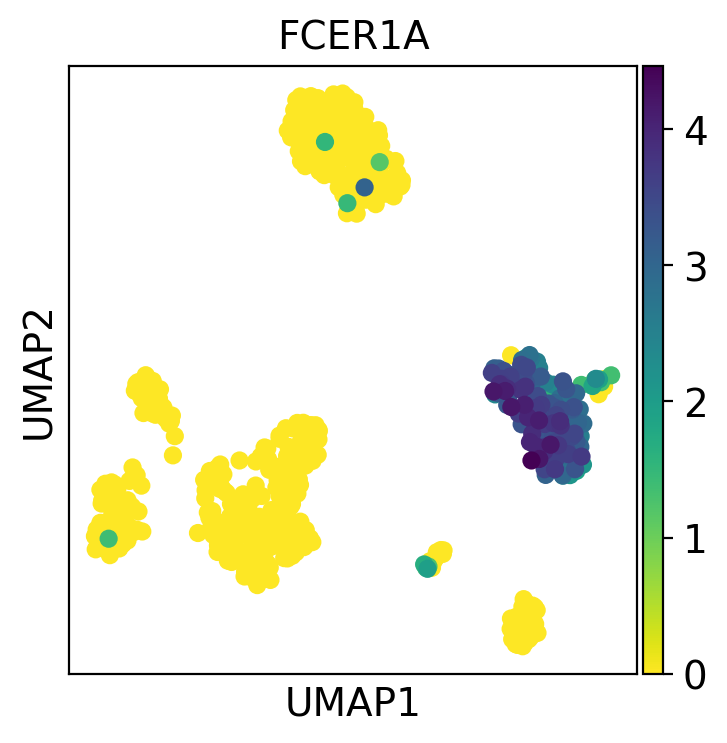

In [14]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(pbmc, color='FCER1A')

><b>Task:</b> Try re-creating your heat map with other marker genes. Specifically, you can use "CD79B", "MS4A1", "LTB", "IGJ", "MZB1", "SPCS2", "FKBP11", "HNRNPA1", "NPM1", "SNHG7", "RPS24", "CD3D", "LDHB", "AES", "CD3E", "NKG7", "CTSW", "GZMA", "GNLY", "FTL", "AIF1", "LST1", "FCGR3A", "PPP1R14A", "GPX1", "PLAC8", "S100A10", "FCER1A", "LYZ", "HLA-DRB1", "HLA-DRA", "IRF8", "HLA-DPA1", "CPVL", and "CST3". 

><b>Task:</b> Go to the [NCBI website]('https://www.ncbi.nlm.nih.gov/gene/') and research one of the above marker genes. What does your marker gene do? Where is it known to be expressed?

We can make a bunch of UMAP plots showing expression levels of multiple genes:

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


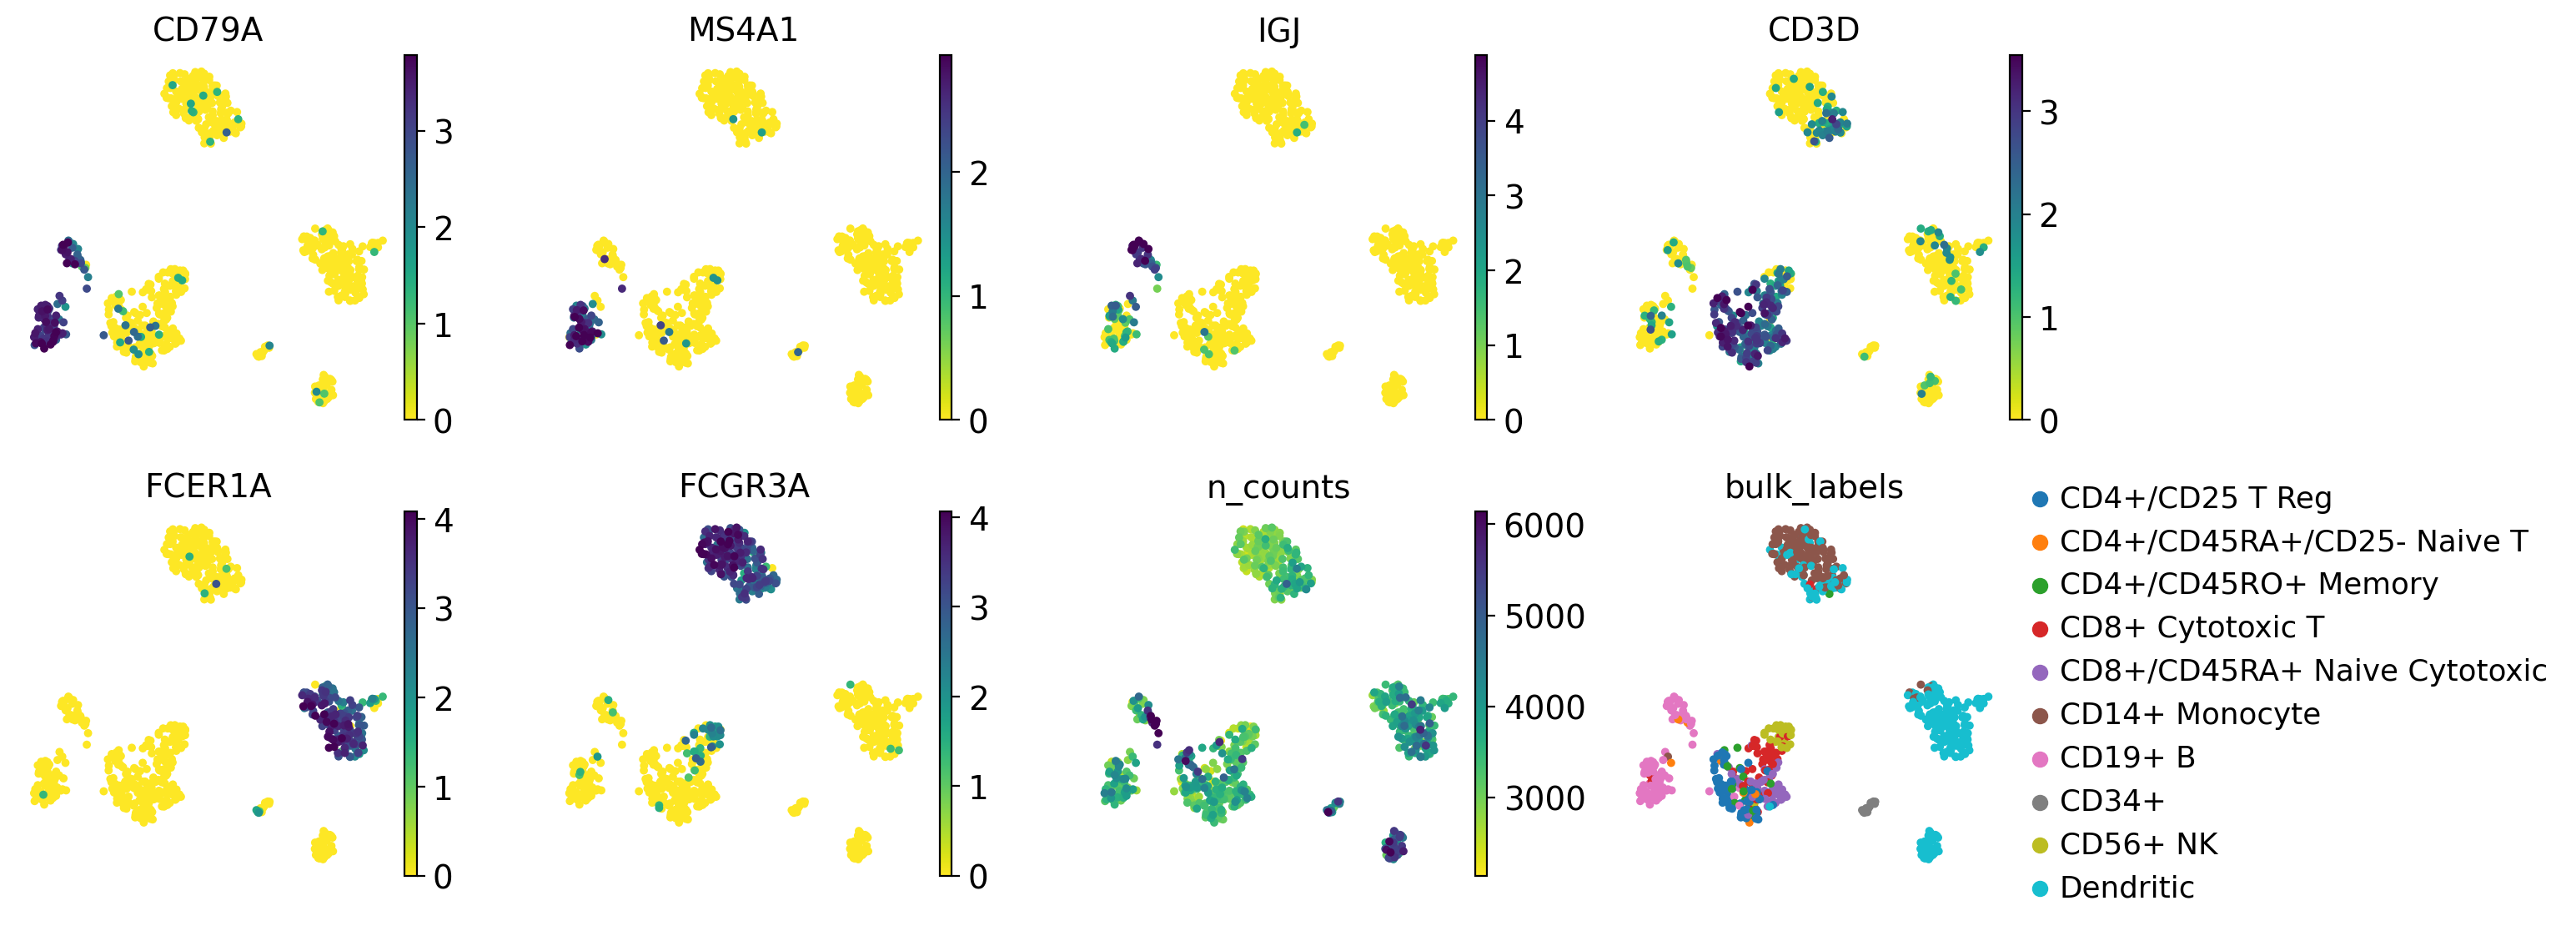

In [15]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(pbmc, color=['CD79A', 'MS4A1', 'IGJ', 'CD3D', 'FCER1A', 'FCGR3A', 'n_counts', 'bulk_labels'], s=50, frameon=False, ncols=4, vmax='p99')

Question: What seem to be some good marker genes for our data? Take the gene "FCGR3A", for example - which cell type does this gene appear to come from? Take a look at the "n_counts" plot - in this case, "counts" correspond roughly to the number of transcripts detected. Which cell type expresses the most genes in our sample?

The functions for scatterplots have many options that allow fine tuning of the images. For example, we can look at the clustering as follows:

In [16]:
# compute clusters using the leiden method and store the results with the name `clusters`
sc.tl.leiden(pbmc, key_added='clusters', resolution=0.5)

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


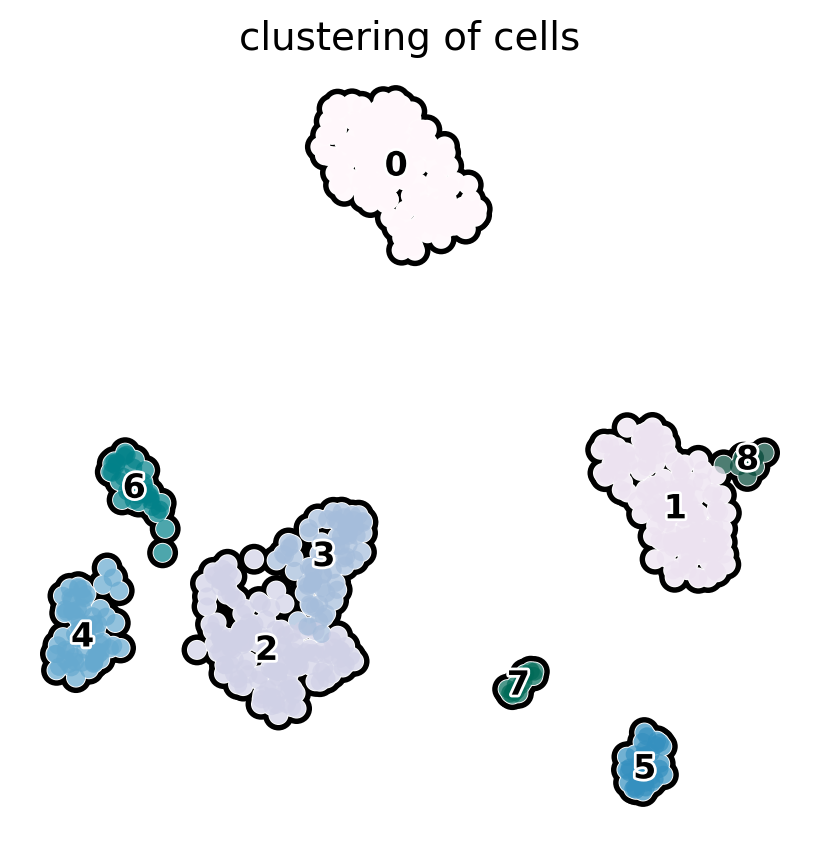

In [24]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(pbmc, color='clusters', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='clustering of cells', palette='PuBuGn')

><b>Task:</b> Re-plot your UMAP using different color palettes. For a list of colormap options, look [here]('https://matplotlib.org/stable/tutorials/colors/colormaps.html').

##Identification of Clusters Based on Known Marker Genes

Frequently, clusters need to be labelled using well known marker genes. Using scatter plots we can see the expression of a gene and perhaps associate it with a cluster. Here, we will show other visual ways to associate marker genes to clusters using dotplots, violin plots, heatmaps and something that we call ‘tracksplot’. All of these visualizations summarize the same information, expression split by cluster, and the selection of the best results is left to the investigator do decide.

First, we set up a dictionary with the marker genes, as this will allow `scanpy` to automatically label the groups of genes:

In [25]:
marker_genes_dict = {
    'B-cell': ['CD79A', 'MS4A1'],
    'Dendritic': ['FCER1A', 'CST3'],
    'Monocytes': ['FCGR3A'],
    'NK': ['GNLY', 'NKG7'],
    'Other': ['IGLL1'],
    'Plasma': ['IGJ'],
    'T-cell': ['CD3D'],
}

A quick way to check the expression of these genes per cluster is to using a dotplot. This type of plot summarizes two types of information: the color represents the mean expression within each of the categories (in this case in each cluster) and the dot size indicates the fraction of cells in the categories expressing a gene.

Also, it is also useful to add a dendrogram to the graph to bring together similar clusters. The hierarchical clustering is computed automatically using the correlation of the PCA components between the clusters:

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


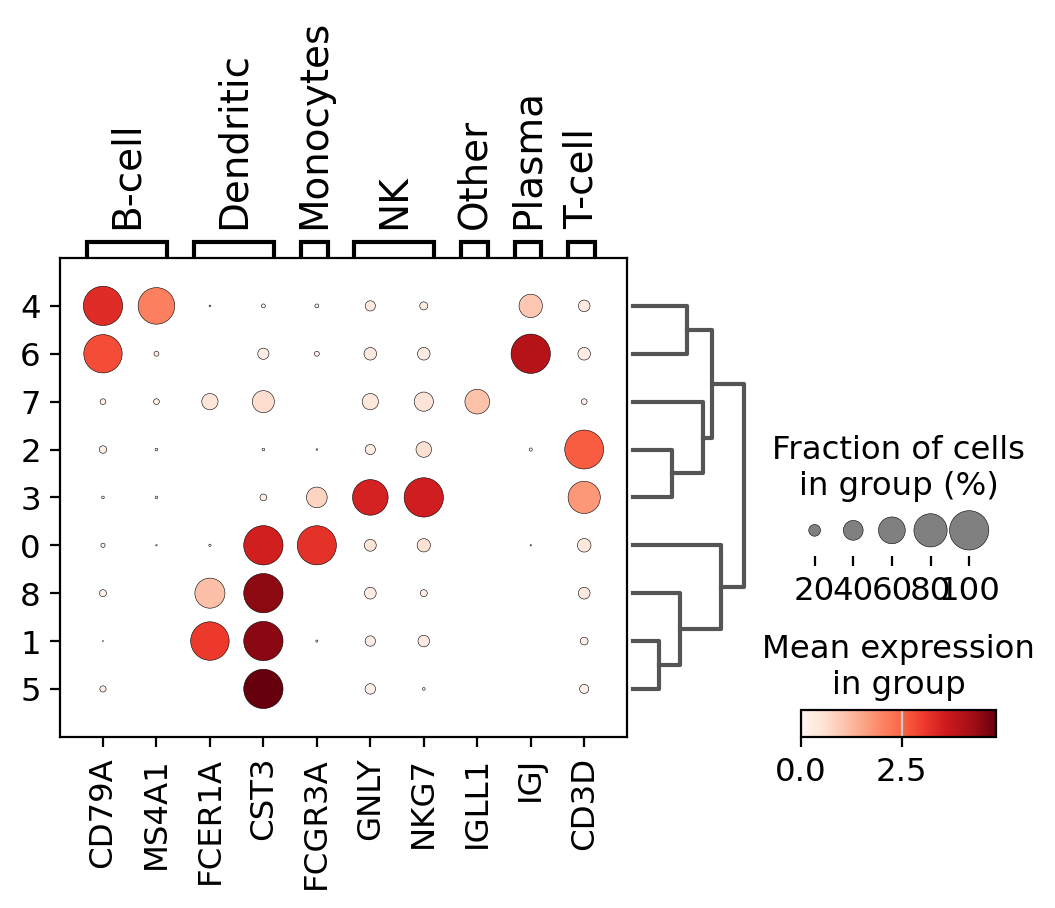

In [26]:
sc.pl.dotplot(pbmc, marker_genes_dict, 'clusters', dendrogram=True)

Using this plot, we can see that cluster 4 correspond to B-cells, cluster 2 is T-cells etc. This information can be used to manually annotate the cells as follows:

In [27]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Monocytes',
     '1': 'Dendritic',
     '2': 'T-cell',
     '3': 'NK',
     '4': 'B-cell',
     '5': 'Dendritic',
     '6': 'Plasma',
     '7': 'Other',
     '8': 'Dendritic',
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
pbmc.obs['cell type'] = pbmc.obs['clusters'].map(cluster2annotation).astype('category')

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


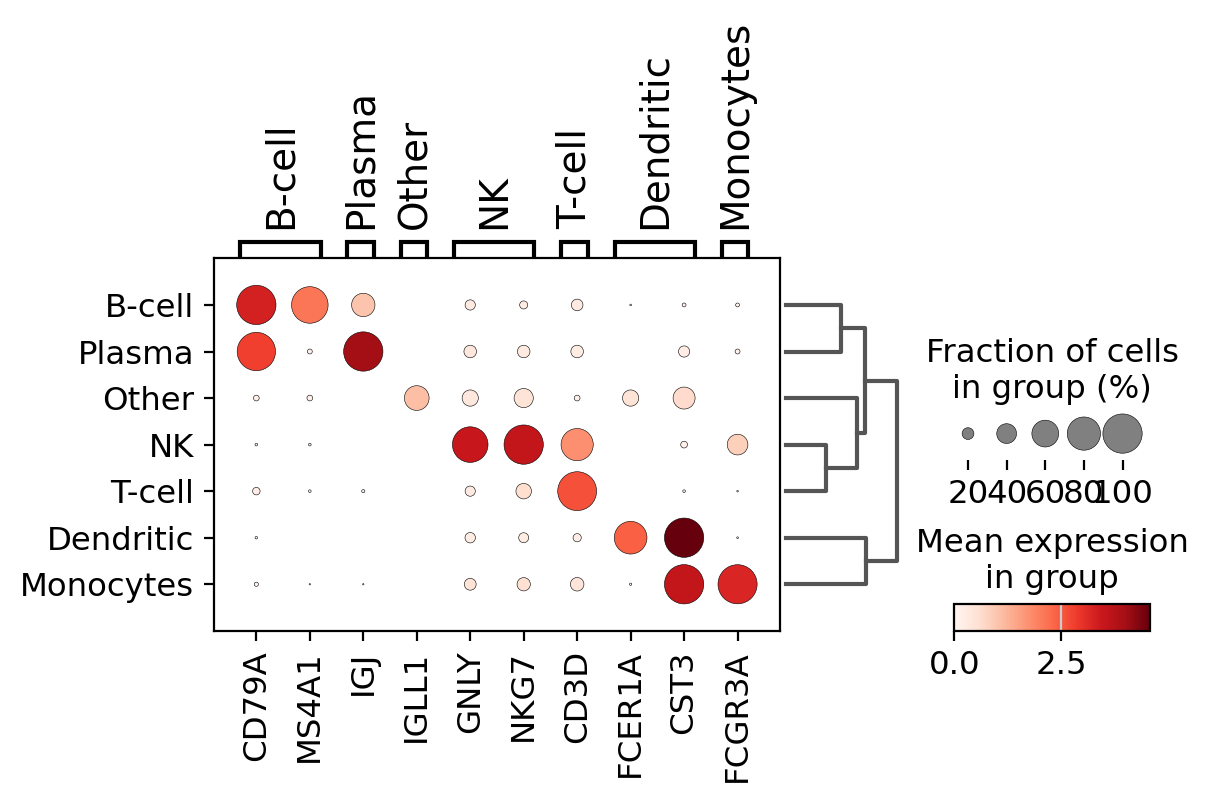

In [28]:
sc.pl.dotplot(pbmc, marker_genes_dict, 'cell type', dendrogram=True)

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


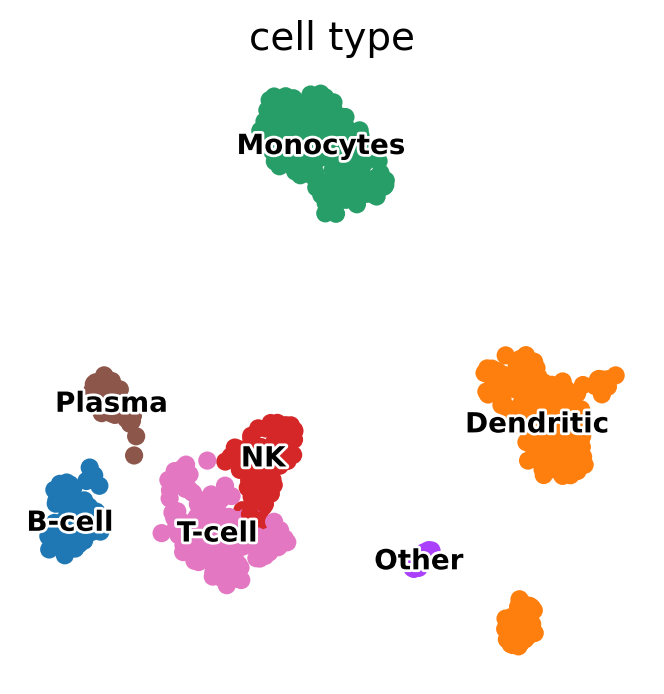

In [29]:
sc.pl.umap(pbmc, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

A different way to explore the markers is with violin plots. Here we can see the expression of "CD79A" in clusters 5 and 8, and "MS4A1" in cluster 5.Compared to a dotplot, the violin plot gives us and idea of the distribution of gene expression values across cells.

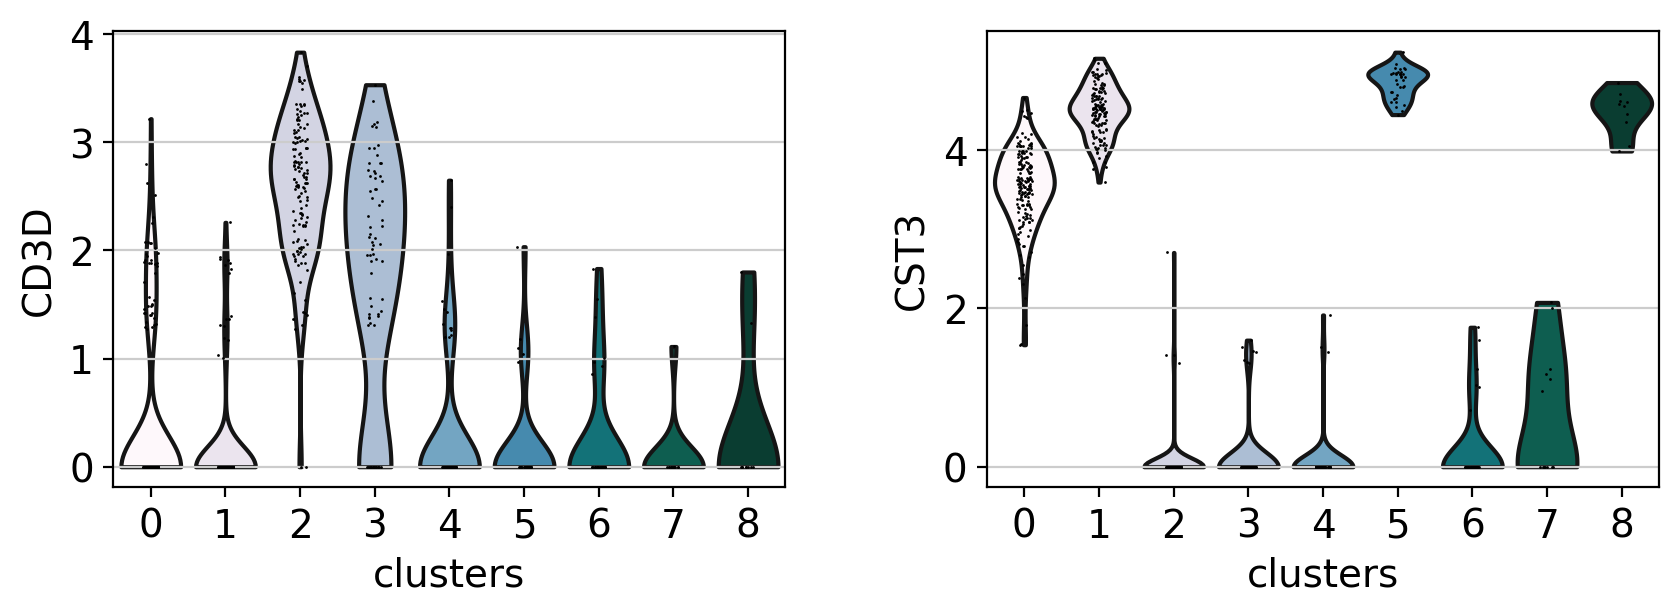

In [34]:
with rc_context({'figure.figsize': (4.5, 3)}):
    sc.pl.violin(pbmc, ['CD3D', 'CST3'], groupby='clusters' )

><b>Task:</b> Create violin plots of different genes in the <code>pmbc</code> dataset. What do the distributions of these genes across cells in each cluster look like? Do cell types have normally distributed patterns of gene expression?

**Note**: Violin plots can also be used to plot any numerical value stored in `.obs`. For example, here violin plots are used to compare the number of genes and the percentage of mitochondrial genes between the different clusters:

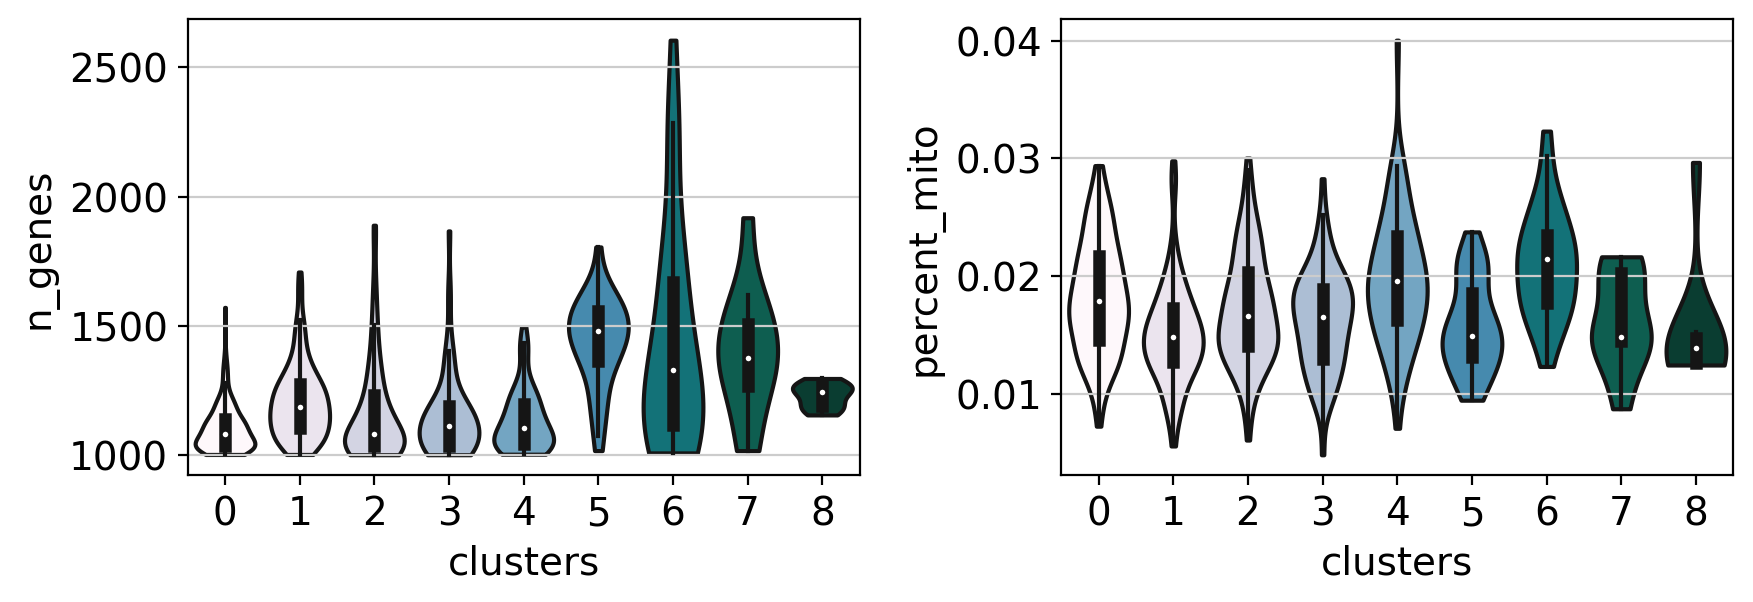

In [35]:
with rc_context({'figure.figsize': (4.5, 3)}):
    sc.pl.violin(pbmc, ['n_genes', 'percent_mito'], groupby='clusters', stripplot=False, inner='box')  # use stripplot=False to remove the internal dots, inner='box' adds a boxplot inside violins

To simultaneously look at the violin plots for all marker genes we use `sc.pl.stacked_violin`. As previously, a dendrogram was added to group similar clusters.

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


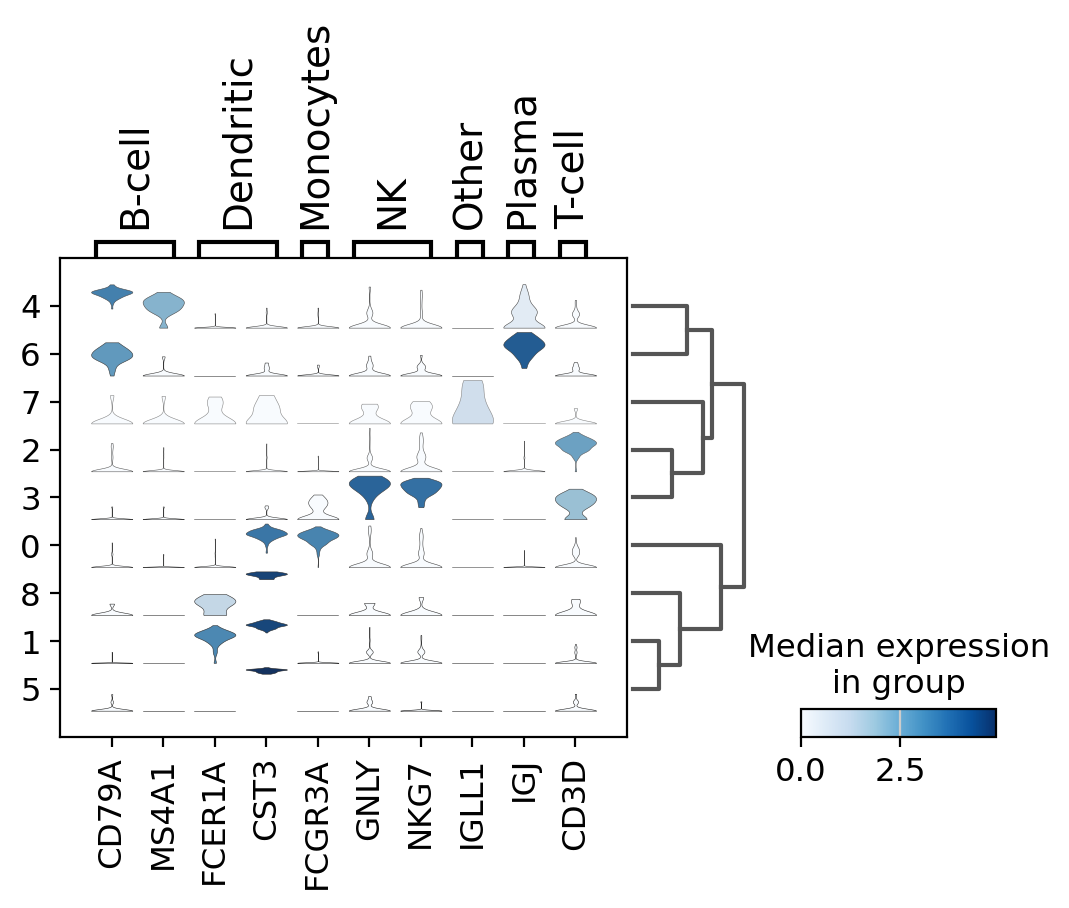

In [36]:
ax = sc.pl.stacked_violin(pbmc, marker_genes_dict, groupby='clusters', swap_axes=False, dendrogram=True)

A simple way to visualize the expression of genes is with a matrix plot. This is a heatmap of the mean expression values per gene grouped by categories. This type plot basically shows the same information as the color in the dotplots.

Here, scale the expression of the genes from 0 to 1, being the maximum mean expression and 0 the minimum.

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


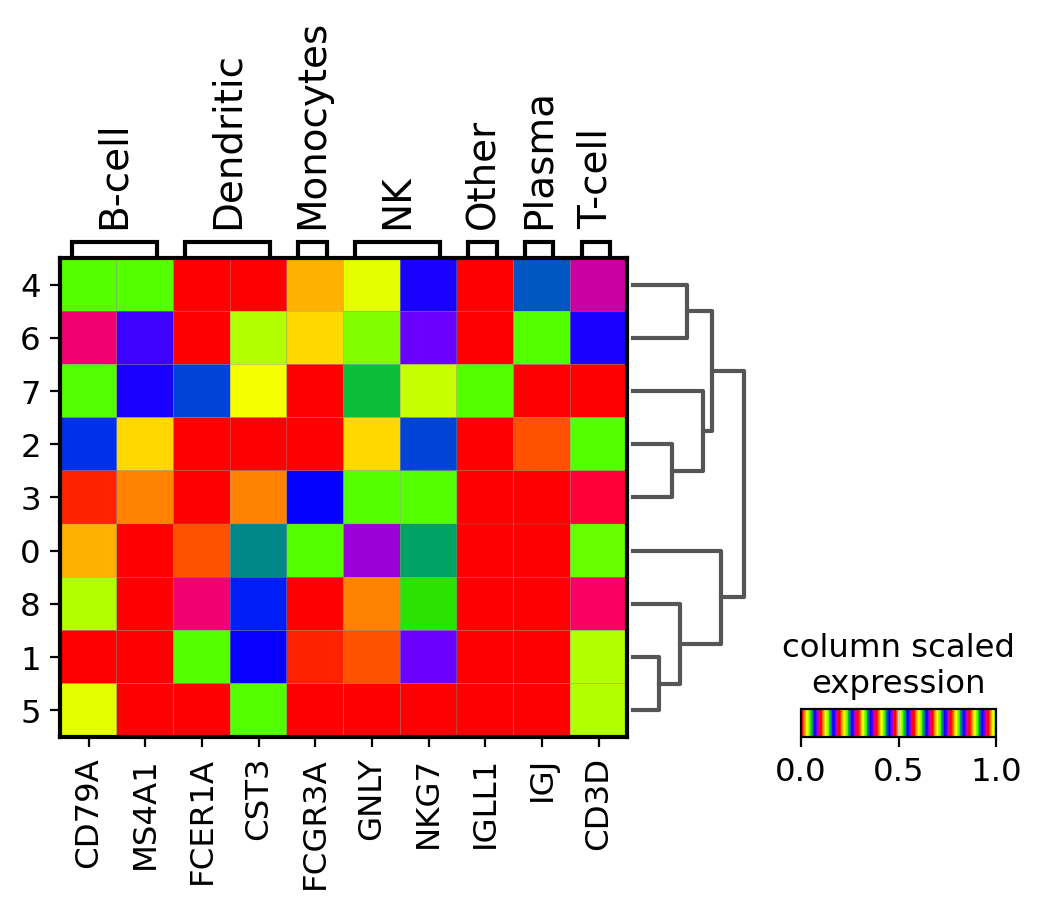

In [47]:
sc.pl.matrixplot(pbmc, marker_genes_dict, 'clusters', dendrogram=True, cmap='prism', standard_scale='var', colorbar_title='column scaled\nexpression')

><b>Task:</b> Make your matrix plot different colors by changing the <code>cmap</code> input!

One other useful option is to normalize the gene expression using `sc.pp.scale`. Here we store this information under the `scale` layer. Afterwards we adjust the plot min and max and use a diverging color map (in this case `RdBu_r` where `_r` means reversed).

In [45]:
# scale and store results in layer
pbmc.layers['scaled'] = sc.pp.scale(pbmc, copy=True).X

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


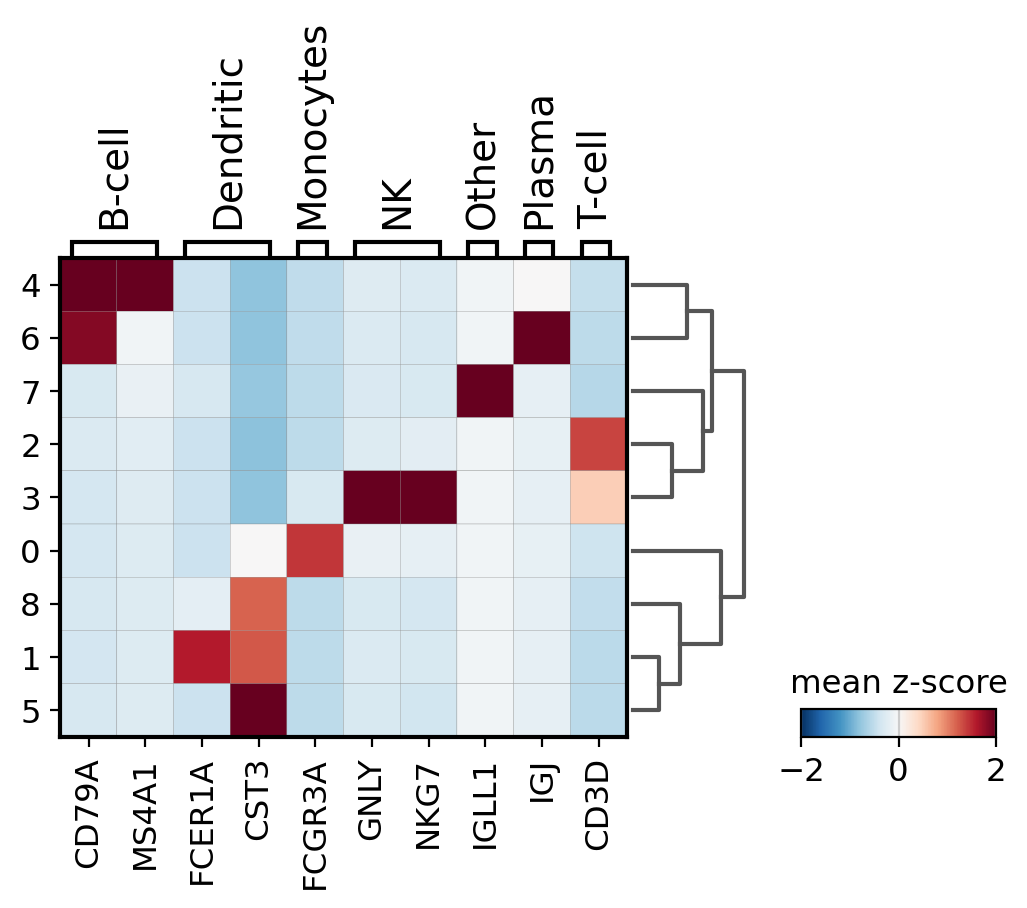

In [46]:
sc.pl.matrixplot(pbmc, marker_genes_dict, 'clusters', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r')

##Combining Plots in Subplots

An `axis` can be passed to a plot to combine multiple outputs as in the following example:

/usr/local/lib/python3.9/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


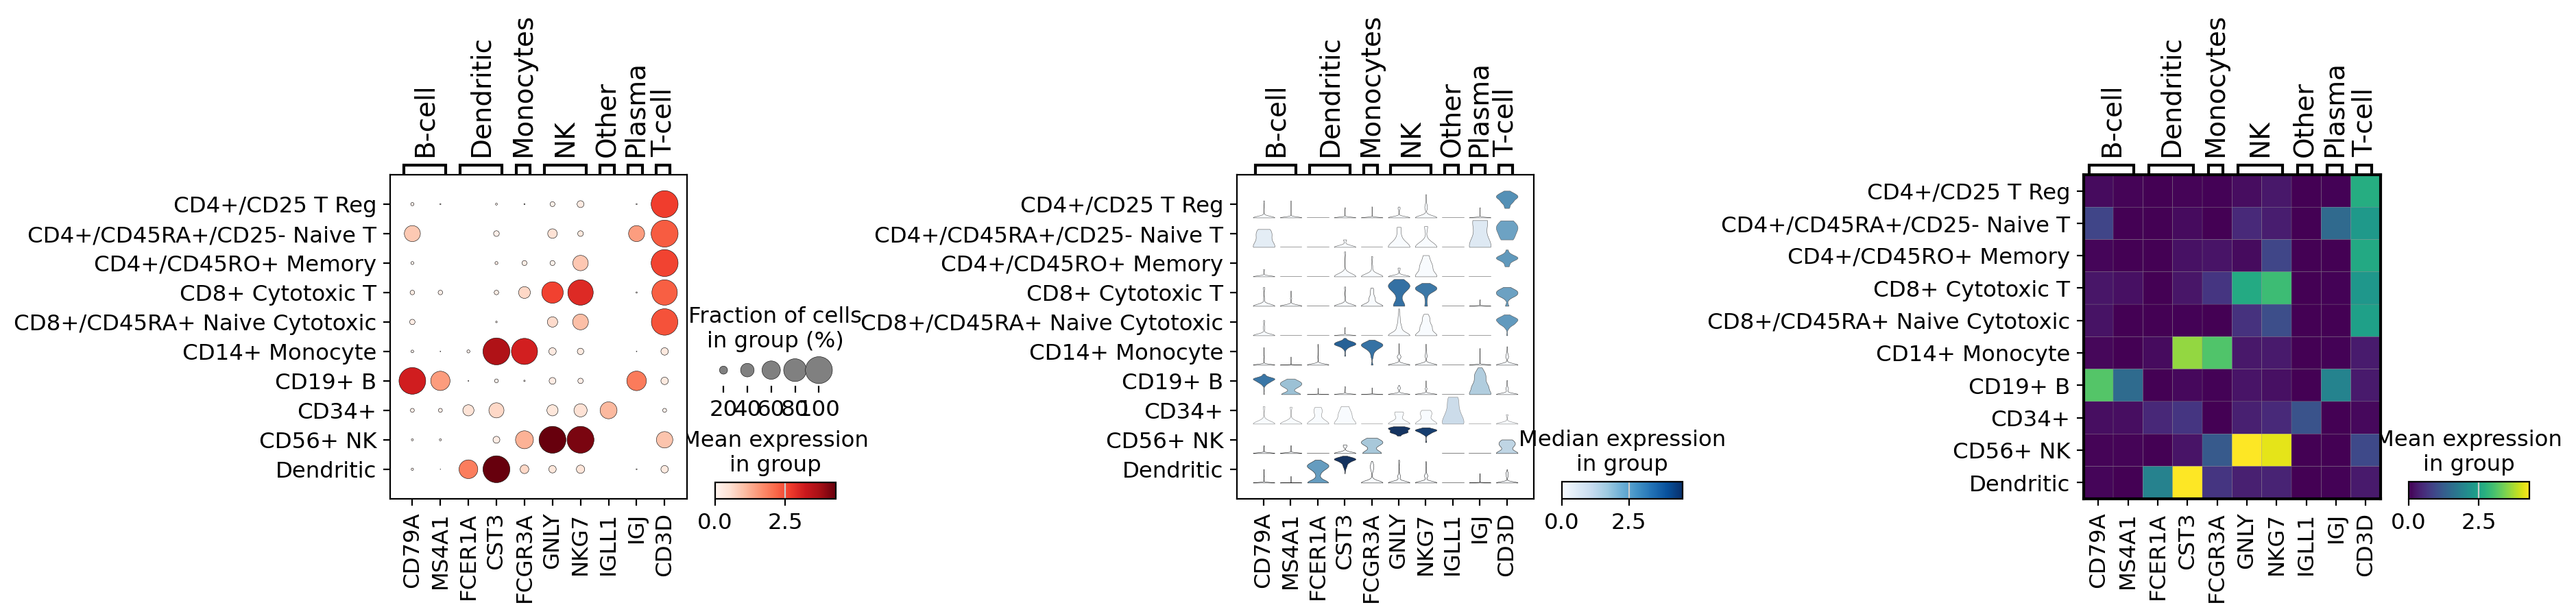

In [48]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4), gridspec_kw={'wspace':0.9})

ax1_dict = sc.pl.dotplot(pbmc, marker_genes_dict, groupby='bulk_labels', ax=ax1, show=False)
ax2_dict = sc.pl.stacked_violin(pbmc, marker_genes_dict, groupby='bulk_labels', ax=ax2, show=False)
ax3_dict = sc.pl.matrixplot(pbmc, marker_genes_dict, groupby='bulk_labels', ax=ax3, show=False, cmap='viridis')

Heatmaps do not collapse cells as in previous plots. Instead, each cell is shown in a row (or column if `swap_axes=True`). The groupby information can be added and is shown using the same color code found for `sc.pl.umap` or any other embedding.

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


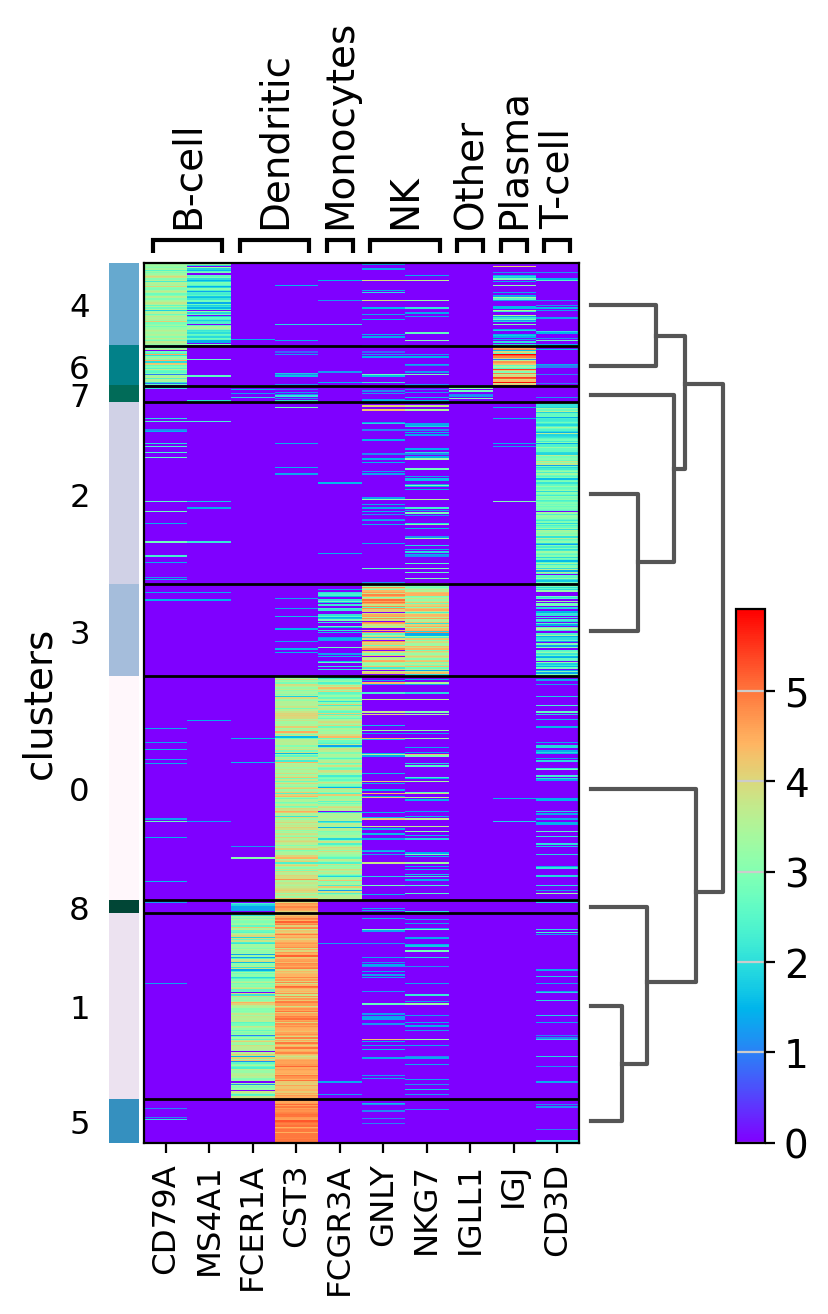

In [51]:
ax = sc.pl.heatmap(pbmc, marker_genes_dict, groupby='clusters', cmap='rainbow', dendrogram=True)

><b>Task:</b> Swap the axes for the heatmap above to put cells on the x-axis instead of the y-axis. 

The heatmap can also be plotted on scaled data. In the next image, similar to the previus matrix plot the min and max had been adjusted and a divergent color map is used.

In [ ]:
ax = sc.pl.heatmap(pbmc, marker_genes_dict, groupby='clusters', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r', dendrogram=True, swap_axes=True, figsize=(11,4))


The track plot shows the same information as the heatmap, but, instead of a color scale, the gene expression is represented by height.

In [ ]:
ax = sc.pl.tracksplot(pbmc, marker_genes_dict, groupby='clusters', dendrogram=True)

##Visualization of Marker Genes

Instead of characterizing clusters by known gene markers as previously, we can identify genes that are differentially expressed in the clusters or groups.

To identify differentially expressed genes we run `sc.tl.rank_genes_groups`. This function will take each group of cells and compare the distribution of each gene in a group against the distribution in all other cells not in the group. Here, we will use the original cell labels given by 10x to identify marker genes for those cell types.

In [ ]:
sc.tl.rank_genes_groups(pbmc, groupby='clusters', method='wilcoxon')


The dotplot visualization is useful to get an overview of the genes that show differential expression. To make the resulting image more compact we will use `n_genes=4` to show only the top 4 scoring genes.

In [ ]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=4)


><b>Task:</b> Change the number of differentially-expressed genes to 5, 10, and 2. How does the plot change each time?

In order to get a better representation we can plot log fold changes instead of gene expression. Also, we want to focus on genes that have a log fold change >= 3 between the cell type expression and the rest of cells.

In this case we set `values_to_plot='logfoldchanges'` and `min_logfoldchange=3`.

Because log fold change is a divergent scale we also adjust the min and max to be plotted and use a divergent color map. Notice in the following plot that is rather difficult to distinguish between T-cell populations.

In [ ]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=4, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')


><b>Task:</b> Try changing the <code>vmax</code> and <code>vmin</code> parameters. What do these do? Try changing the <code>min_logfoldchange</code> input to "5". What happens to the plot?

##Focusing on Particular Groups

Next, we use a dotplot focusing only on two groups (the groups option is also available for violin, heatmap and matrix plots). Here, we set `n_genes=30` as in this case it will show all the genes that have a `min_logfoldchange=4` up to 30.

In [ ]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=30, values_to_plot='logfoldchanges', min_logfoldchange=4, vmax=7, vmin=-7, cmap='bwr', groups=['1', '5'])


><b>Task:</b> Change the groups that you want to look at. How does expression of the 30 genes differ in these groups?

We can also visualize all of these marker genes in a heatmap:

In [ ]:
sc.pl.rank_genes_groups_heatmap(pbmc, n_genes=3, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(10,7), show=False);

Showing 10 genes per category, turning the gene labels off and swapping the axes. Notice that when the image is swapped, a color code for the categories appear instead of the ‘brackets’.

In [ ]:
sc.pl.rank_genes_groups_heatmap(pbmc, n_genes=10, use_raw=False, swap_axes=True, show_gene_labels=False,
                                vmin=-3, vmax=3, cmap='bwr')

And a tracksplot:

In [ ]:
sc.pl.rank_genes_groups_tracksplot(pbmc, n_genes=3)


You may have noticed that, as the number of marker genes increases, the clusters get more complex, as there is more cluster overlap between less differentially-expressed gene sets. One way to visualize the divergence between these clusters is with a dendrogram:

In [ ]:
# compute hierarchical clustering using PCs (several distance metrics and linkage methods are available).
sc.tl.dendrogram(pbmc, 'bulk_labels')

ax = sc.pl.dendrogram(pbmc, 'bulk_labels')

We can compute correlations between clusters to see how they map onto the dendrogram:

In [ ]:
ax = sc.pl.correlation_matrix(pbmc, 'bulk_labels', figsize=(5,3.5))